

# Comparativa de técnicas de Regresión Logística y Naïve Bayes para detectar publicaciones de personas con rasgos depresivos en redes sociales





#Importe e instalación de API's a usar



In [ ]:
!pip install psaw
!pip install contractions
!pip install beautifulsoup4
!pip install -q praw

import praw
from psaw import PushshiftAPI
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np


'''Preprocesamiento'''
import contractions
from bs4 import BeautifulSoup
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import itertools, string, operator, re, unicodedata, nltk
from operator import itemgetter
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from nltk.tokenize import TweetTokenizer, RegexpTokenizer



from itertools import combinations
from gensim.models import Phrases
from collections import Counter
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Clasificadores'''
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

'''Metricas'''
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

'''Display'''
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

     |████████████████████████████████| 245kB 12.5MB/s 
     |████████████████████████████████| 317kB 24.6MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81699 sha256=9ddc46a9b52fcdc817625856e38c89c4f13908c0648d34ad384627f476404e00
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick
     |████████████████████████████████| 153kB 9.3MB/s 
     |████████████████████████████████| 204kB 14.7MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
r = praw.Reddit(client_id='DVMXLvmsxd7YxA', client_secret='3YDck35pBbQuunBHBojaykud9pM', user_agent='depresssionApp')
api = PushshiftAPI(r)

In [ ]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
#Obtencion de la data de /suicideWatch
posts = []
ml_subreddit = api.search_submissions(subreddit='SuicideWatch',limit=50000)
for post in ml_subreddit:
    posts.append([post.selftext,post.title, 'Suicida'])
neg_posts = pd.DataFrame(posts,columns=['body','titulo', 'label'])
neg_posts['body']=neg_posts['body'] + neg_posts['titulo']
neg_posts.shape

(5000, 3)

In [ ]:
#Obtencion de la data /CasualConversation
posts = []
ml_subreddit = api.search_submissions(subreddit='CasualConversation',limit=50000)
for post in ml_subreddit:
    posts.append([post.selftext,post.title, 'Controlado'])
normal_posts = pd.DataFrame(posts,columns=['body','titulo', 'label'])
normal_posts['body']=normal_posts['body'] + normal_posts['titulo']
normal_posts.shape

(5000, 3)

In [ ]:
frames = [neg_posts, normal_posts]
data = pd.concat(frames)
data.shape

(10000, 3)

In [ ]:
data['body'] = data['body'].str.replace('removed', ' ')
data['body'] = data['body'].str.replace('deleted', ' ')
data.head()

,body,titulo,label
0,"I’m not a terrible or that bad of a player. In fact at one point I was part of a militarize like clan and was a squad leader. But I like pretend the Avatar is really me and I run into the most fucked situations carelessly cuz I secretly wish it was me. Slide on to a trip mine to clear the way for team mates. Lay on a grenade to save everyone else, running with a live grenade into enemy strongholds, put C4 on my back then just out of a helicopter on to a group of enemies like a guided suicide bomber. All things I was really have no problem doing in real too. My only regret would be I could only do it one time. But maybe be some one would be thankful I was around then.I play Call of Duty cuz I envy the lil guy when he dies.",I play Call of Duty cuz I envy the lil guy when he dies.,Suicida
1,"On every thread I see there are people urging others not to do it because life gets better. It might for some people but for some people it doesn’t. You can learn new skills to cope and manage your life better but when it comes to finding love and friendships and community, that is mostly out of your control. And for some people that never happens. Why would people lie about that? I’m just wondering if people want to share their thoughts. It seems cruel to give people false hope, but maybe my perspective is skewed.Why do people keep saying things get better?",Why do people keep saying things get better?,Suicida
2,Im going to go on a holiday to my home country (Pakistan) where my cousins live. And I'm gonna go out everywhere hoping I get corona virus. Then hopefully I'll die from that. \n\nBut what are the chances u'll survive from COVID-19?I have a good idea.,I have a good idea.,Suicida
3,"I don't know where to start and I don't know why I'm doing this\n\n18 years old (F) from France,\n\nBeen struggling for most of my short existence, I remember being 10 only and learning about the future medical issues I'd have to encounter, nothing bad, everyone has issues, who gives a fuck. Been bullied aswell, again nothing special, but at this point I started cutting myself, I've been doing it for 7 years, I'm tired, I feel ugly and my body is completely deformed.\n\nI live in a religious (muslim) household, can't talk about anything, I would just hide shit, I never got to talk about feelings, at every dinner I always felt so attacked because my family has such extreme views on everything. Which is also funny when you learn that my father is a raging alcoholic who did many disturbing things.\n\nI fell in love more than once, I can't help it, I believe it's normal for teenagers to start and develop feelings for others. Having no friends I'd just fall in love with some guys over the internet throughout the years, 3 lovers in total, always turned to shit, cheating lying and all that, I guess I deserved it, I've always been a stupid retarded attention seeker, nothing bad.\n\nWith that, my brother would just spy on me and discovered I once sent nudes to my boyfriend, we live under the same roof and he didn't speak to me once in two years, all I get from him is insults about how much of a disgusting whore and a horrible liar I am, he kept looking for more stuff I sent, I don't know why he would keep looking at that... he used to be my best friend. My parents agree and they just don't care about me.\n\nI remember the time I would only smoke joints and cigarettes. Since last year I've been on a rampage, been mixing pills with alcohol and it's the only thing that makes me forget, along with cutting it just feels like I can stop myself from crying for a bit.\n\nI've had multiple psychosis and I ended in a hospital 6 months ago, my entire family says I'm an attention seeker. Few years ago I tried to end my life and my father spat on my face when I was just laying there with the knife in my hand.\n\nAfter being disappointed in most of my relationships and feeling so insecure about myself, I would try to get reassurance from as many men (some o

In [ ]:
data.label.value_counts()

Controlado    5000
Suicida       5000
Name: label, dtype: int64

# Preprocesamiento


In [ ]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text


def expand_contractions(text):
    return contractions.fix(text)


def pre_process_document(document):
    # Elimina los tags de HTML
    document = strip_html_tags(document)
    # Elimina los espacios y saltos
    document = document.translate(document.maketrans("\n\t\r", "   "))
    # Elimina los acentos
    document = remove_accented_chars(document)
    # Expande las contracciones
    document = expand_contractions(document)     
    # Elimina caracteres o digitos especiales   
    # insertar espacios entre caracteres especiales para aislarlos   
    special_char_pattern = re.compile(r'([{.(-)!}])')
    document = special_char_pattern.sub(" \\1 ", document)
    document = remove_special_characters(document, remove_digits=True)  
    # Minúscula
    document = document.lower()
    # Elimina los espacios en blanco extras
    document = re.sub(' +', ' ', document)
    document = document.strip()
    return document

pre_process_corpus = np.vectorize(pre_process_document)

In [ ]:
data['Limpio']= pre_process_corpus(data['body'])

In [ ]:
data['body'].iloc[[0]]

0    I’m not a terrible or that bad of a player. In fact at one point I was part of a militarize like  clan and was a squad leader. But I like pretend the Avatar is really me and I run into the most fucked situations carelessly cuz I secretly wish it was me. Slide on to a trip mine to clear the way for team mates. Lay on a grenade to save everyone else, running with a live grenade into enemy strongholds, put C4 on my back then just out of a helicopter on to a group of enemies like a guided suicide bomber. All things I was really have no problem doing in real too. My only regret would be I could only do it one time. But maybe be some one would be thankful I was around then.I play Call of Duty cuz I envy the lil guy when he dies.
Name: body, dtype: object

In [ ]:
word_tokens = []
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
stop_words = stopwords.words('english')
nltk.download('wordnet')
tokenizer = TweetTokenizer()

def get_word_net_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemma_wordnet(tagged_text):
    final = []
    for word, tag in tagged_text:
        wordnet_tag = get_word_net_pos(tag)
        if wordnet_tag is None:
            final.append(lemmatizer.lemmatize(word))
        else:
            final.append(lemmatizer.lemmatize(word, pos=wordnet_tag))
    return final

def casual_tokenizer(text): 
    tokens = tokenizer.tokenize(text)
    return tokens



def process_text(text):
    tokenized = casual_tokenizer(text)
    tagged = nltk.pos_tag(tokenized)
    lemma = lemma_wordnet(tagged)
    no_stop = [w for w in lemma if w not in stop_words]
    return no_stop

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
nltk.download('averaged_perceptron_tagger')
data['Token2'] = data['Limpio'].apply(process_text)
data['Token2'].head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


0    [terrible, bad, player, fact, one, point, part, militarize, like, clan, squad, leader, like, pretend, avatar, really, run, fucked, situation, carelessly, cuz, secretly, wish, slide, trip, mine, clear, way, team, mate, lay, grenade, save, everyone, else, run, live, grenade, enemy, stronghold, put, c, back, helicopter, group, enemy, like, guided, suicide, bomber, thing, really, problem, real, regret, would, could, one, time, maybe, one, would, thankful, around, play, call, duty, cuz, envy, lil, guy, die]                                                                                                                                                                                                                                                                 
1    [every, thread, see, people, urge, others, life, get, good, might, people, people, learn, new, skill, cope, manage, life, well, come, find, love, friendship, community, mostly, control, people, never, happen, would, people, l

In [ ]:
def word_count(text):
    return len(str(text).split(' '))

def word_freq(clean_text_list, top_n):
    """
    Word Frequency
    """
    flat = [item for sublist in clean_text_list for item in sublist]
    with_counts = Counter(flat)
    top = with_counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame([word, num]).T

def word_freq_bigrams(clean_text_list, top_n):
    """
    Word Frequency With Bigrams
    """
    bigram_model = Phrases(clean_text_list, min_count=2, threshold=1)
    w_bigrams = list(bigram_model[clean_text_list])
    flat_w_bigrams = [item for sublist in w_bigrams for item in sublist]
    with_counts = Counter(flat_w_bigrams)
    top = with_counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame([word, num]).T


def bigram_freq(clean_text_list, top_n):
    bigram_model = Phrases(clean_text_list, min_count=2, threshold=1)
    w_bigrams = list(bigram_model[clean_text_list])
    flat_w_bigrams = [item for sublist in w_bigrams for item in sublist]
    bigrams = []
    for each in flat_w_bigrams:
        if '_' in each:
            bigrams.append(each)
    counts = Counter(bigrams)
    top = counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame([word, num]).T

In [ ]:
#preparacion de los dataframes
#Se separan en las diferentes categorias
data_Suicida = data.loc[data['label'] =='Suicida']
data_controlado = data.loc[data['label'] =='Controlado']


#Elegir 5 datos de cada categoria para usarlos como pruebas
data_Suicida_holdout = data_Suicida.iloc[:5]
data_controlado_holdout = data_controlado.iloc[:5]

data_Suicida = data_Suicida.iloc[5:]
data_controlado = data_controlado.iloc[5:]

#Volver a juntar los datos y los datos de reserva
data = pd.concat([data_Suicida, data_controlado])
data_holdout = pd.concat([data_Suicida_holdout, data_controlado_holdout])

#Volver las etiquetas a numeros
LE = LabelEncoder()
data['label_num'] = LE.fit_transform(data['label'])

display(data.groupby(['label'])['Token2'].count())
display(data_holdout.groupby(['label'])['Token2'].count())
display(data['label'].unique())
display(data['label_num'].unique())

label
Controlado    4995
Suicida       4995
Name: Token2, dtype: int64

label
Controlado    5
Suicida       5
Name: Token2, dtype: int64

array(['Suicida', 'Controlado'], dtype=object)

array([1, 0])

In [ ]:
top_n = 20

text_sui = data_Suicida['Token2'].tolist()
text_cont = data_controlado['Token2'].tolist()

sui = word_freq_bigrams(text_sui, top_n=top_n)
cont = word_freq_bigrams(text_cont, top_n=top_n)

df_wf = pd.concat([sui, cont], axis=1)
cols = ['sui','cont', 'Controlado','cont']
df_wf.columns = cols
df_wf

,sui,cont,Controlado,cont
0,go,1794,get,917
1,want,1743,like,844
2,know,1605,go,648
3,get,1544,think,616
4,life,1509,know,492
5,like,1432,one,486
6,think,1230,people,463
7,feel_like,1061,time,445
8,even,987,work,432
9,one,913,make,425


In [ ]:
sui_bigrams = bigram_freq(text_sui, top_n=top_n)
cont_bigrams = bigram_freq(text_cont, top_n=top_n)

df_bigram_wf = pd.concat([sui_bigrams, cont_bigrams], axis=1)
df_bigram_wf.columns = cols
df_bigram_wf

,sui,cont,Controlado,cont
0,feel_like,1061,anyone_else,250
1,want_die,388,feel_like,247
2,year_old,176,first_time,124
3,get_good,169,year_old,90
4,really_want,166,httpswww_reddit,82
5,make_feel,162,let_u,76
6,every_day,161,make_feel,70
7,want_kill,156,best_friend,65
8,want_live,149,view_poll,64
9,want_go,127,even_though,51


# TD-IDF Unigram, naive bayes y regresion logistica con parametros estandar

> Bloc con sangría



In [ ]:
texts = data['Token2'].astype('str')

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts) 
y = data['label_num'].values 

print (X.shape)
print(y.shape)

(9990, 8121)
(9990,)


In [ ]:
#Solo para cuando se aplica el gaussian
lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
X.shape

(9990, 100)

In [ ]:

#Evaluacion de modelo preliminar usando parametros por defecto

model_dict = {'Gaussian Naive Bayes': GaussianNB(),
              'Logistic Regression': LogisticRegression()}

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        #Calcula las metricas por cada categoria y halla su media no ponderada
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name - unigram', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)

,model_name - unigram,accuracy_score,precision_score,recall_score,f1_score
1,Logistic Regression,0.85,0.85,0.85,0.85
0,Gaussian Naive Bayes,0.74,0.74,0.74,0.74


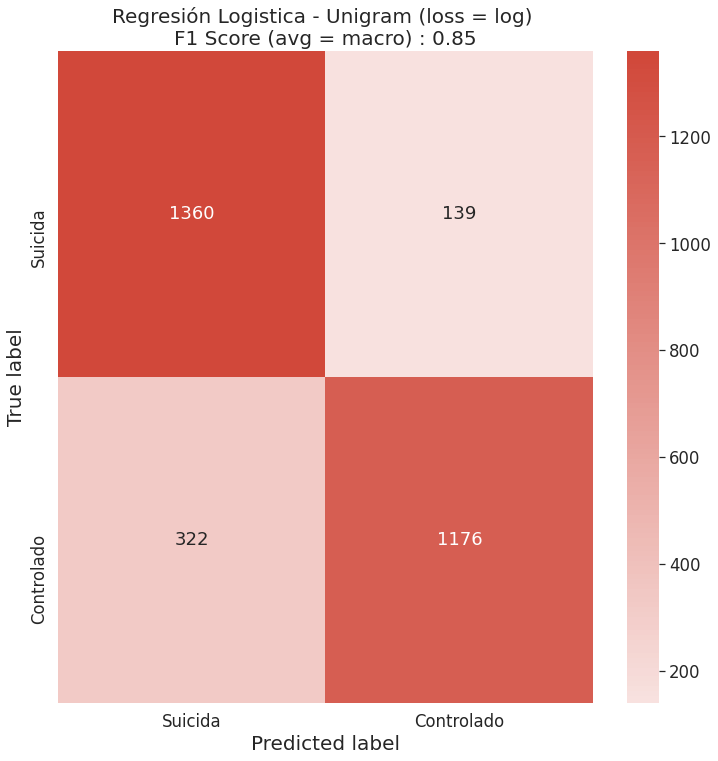

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .30, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred_RL_Uni = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_RL_Uni) 

cm_df = pd.DataFrame(cm,
                     index = ['Suicida','Controlado'], 
                     columns = ['Suicida','Controlado'])
plt.figure(figsize=(12, 12))
sns.set(font_scale=1.5)
sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('Regresión Logistica - Unigram (loss = log) \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred_RL_Uni, average='macro')), fontsize = 20)
plt.ylabel('True label', fontsize = 20)
plt.xlabel('Predicted label', fontsize = 20)
plt.show()

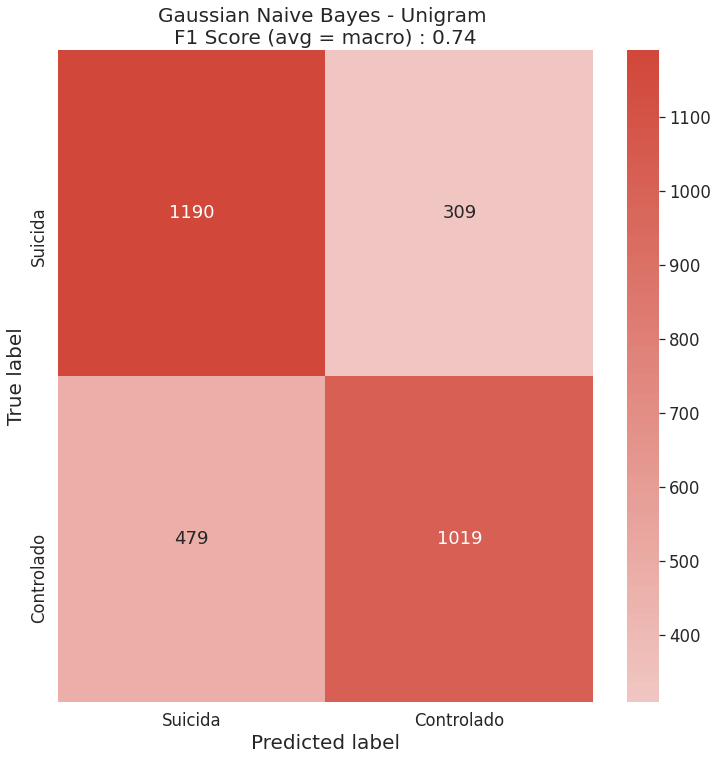

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .30, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)
model = GaussianNB()
model.fit(X_train, y_train)
y_pred_NB_Uni = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_NB_Uni) 

cm_df = pd.DataFrame(cm,
                     index = ['Suicida','Controlado'], 
                     columns = ['Suicida','Controlado'])
plt.figure(figsize=(12, 12))
sns.set(font_scale=1.5)
sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('Gaussian Naive Bayes - Unigram \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred_NB_Uni, average='macro')), fontsize = 20)
plt.ylabel('True label', fontsize = 20)
plt.xlabel('Predicted label', fontsize = 20)
plt.show()

Text(0.5, 1.0, 'Curva ROC - AUC')

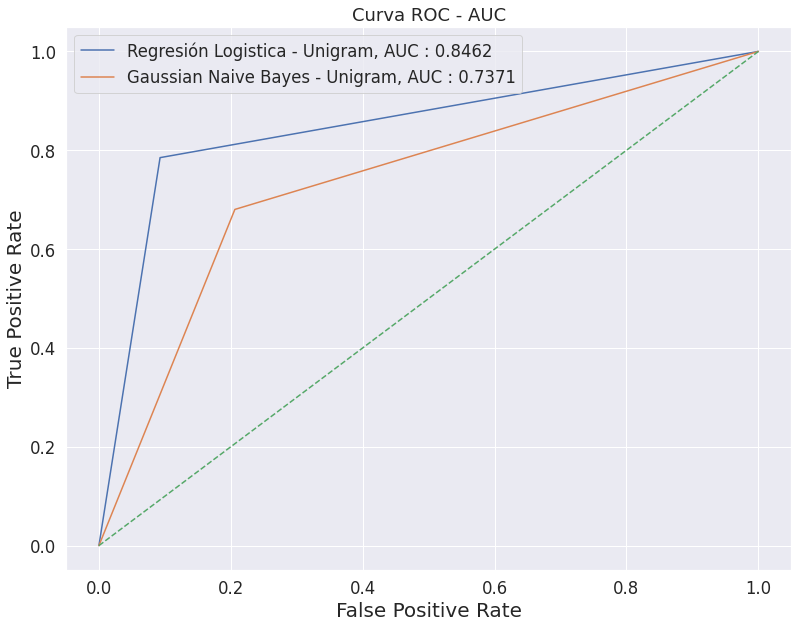

In [ ]:
plt.figure(figsize = (13, 10))
for label,y_pred_prob in zip(["Regresión Logistica - Unigram","Gaussian Naive Bayes - Unigram"],
                    [y_pred_RL_Uni,y_pred_NB_Uni]):
  fpr,tpr,_ = roc_curve(y_test, y_pred_prob)
  plt.plot(fpr, tpr, label=label+str(", AUC : %.4f"%auc(fpr,tpr)))

plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)  
plt.legend()
plt.title('Curva ROC - AUC')

# TD-IDF Bigram, naive bayes y regresion logistica con parametros estandar

In [ ]:
texts = data['Token2'].astype('str')

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts) #features
y = data['label_num'].values #target

print (X.shape)
print(y.shape)

(9990, 40141)
(9990,)


In [ ]:
lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
X.shape

(9990, 100)

In [ ]:

#Evaluacion de modelo preliminar usando parametros por defecto

model_dict = {'Gaussian Naive Bayes': GaussianNB(),
              'Logistic Regression': LogisticRegression()}

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        #Calcula las metricas por cada categoria y halla su media no ponderada
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name - bigram', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)

,model_name - bigram,accuracy_score,precision_score,recall_score,f1_score
1,Logistic Regression,0.74,0.76,0.74,0.73
0,Gaussian Naive Bayes,0.64,0.68,0.64,0.62


Text(0.5, 76.5, 'Predicted label')

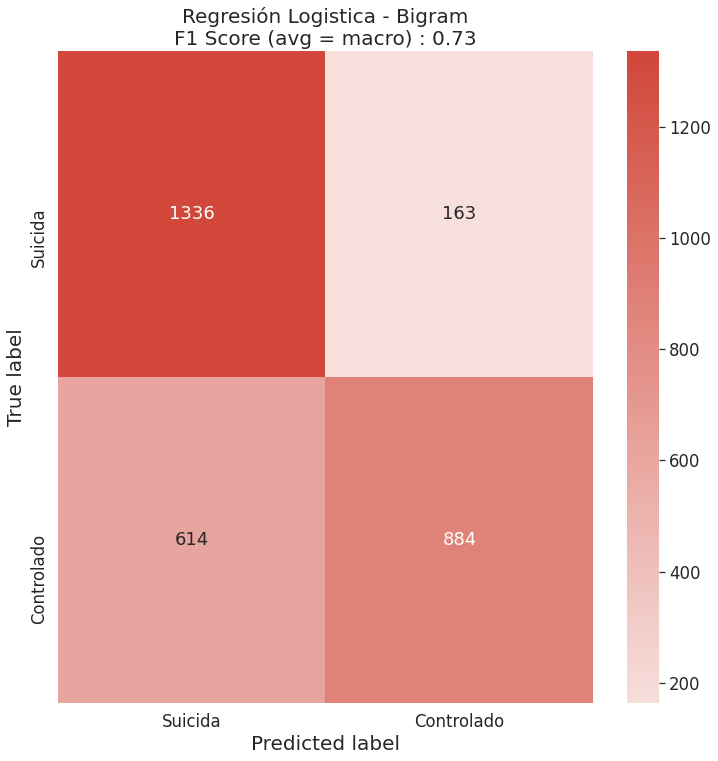

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .30, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred_RL_Bi = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_RL_Bi) 

cm_df = pd.DataFrame(cm,
                     index = ['Suicida','Controlado'], 
                     columns = ['Suicida','Controlado'])
plt.figure(figsize=(12, 12))
sns.set(font_scale=1.5)
sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('Regresión Logistica - Bigram\nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred_RL_Bi, average='macro')), fontsize = 20)
plt.ylabel('True label', fontsize = 20)
plt.xlabel('Predicted label', fontsize = 20)

Text(0.5, 76.5, 'Predicted label')

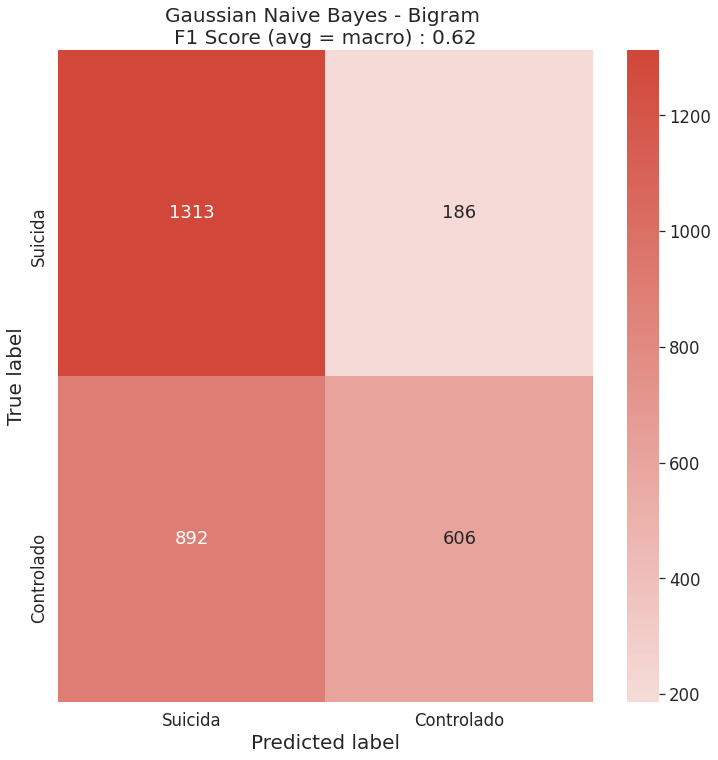

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .30, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)
model = GaussianNB()
model.fit(X_train, y_train)
y_pred_NB_Bi = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_NB_Bi) 

cm_df = pd.DataFrame(cm,
                     index = ['Suicida','Controlado'], 
                     columns = ['Suicida','Controlado'])
plt.figure(figsize=(12, 12))
sns.set(font_scale=1.5)
sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('Gaussian Naive Bayes - Bigram \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred_NB_Bi, average='macro')), fontsize = 20)
plt.ylabel('True label', fontsize = 20)
plt.xlabel('Predicted label', fontsize = 20)

Text(0.5, 1.0, 'Curva ROC - AUC')

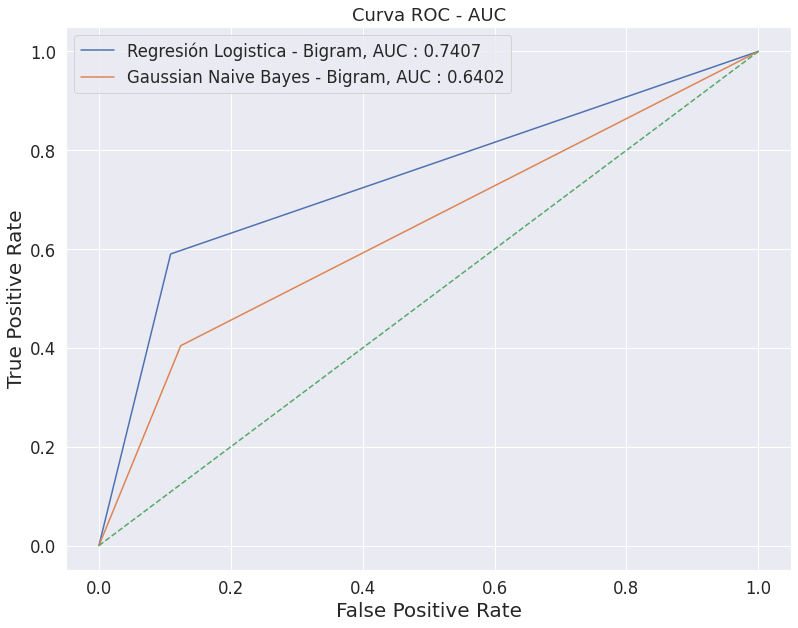

In [ ]:
plt.figure(figsize = (13, 10))
for label,y_pred_prob in zip(["Regresión Logistica - Bigram","Gaussian Naive Bayes - Bigram"],
                    [y_pred_RL_Bi,y_pred_NB_Bi]):
  fpr,tpr,_ = roc_curve(y_test, y_pred_prob)
  plt.plot(fpr, tpr, label=label+str(", AUC : %.4f"%auc(fpr,tpr)))

plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)  
plt.legend()
plt.title('Curva ROC - AUC')

# TD-IDF unigram, implementando los modelos de naive bayes: Bernoulli, Multinomial

In [ ]:
texts = data['Token2'].astype('str')

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts) #features
y = data['label_num'].values #target

print (X.shape)
print(y.shape)

(9990, 8121)
(9990,)


In [ ]:
lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X_Gaussian = lsa.fit_transform(X)
X_Gaussian.shape

(9990, 100)

In [ ]:
#Evaluacion de modelo preliminar usando parametros por defecto

model_dict = {'Gaussian Naive Bayes': GaussianNB(),
              'Bernoulli Naive Bayes': BernoulliNB(),
              'Multinomial Naive Bayes': MultinomialNB(),
              }

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

X_train_G, X_test_G, y_train_G, y_test_G = train_test_split(X_Gaussian, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)


def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():
        if k=='Gaussian Naive Bayes':
          model_name.append(k)
          v.fit(X_train_G, y_train_G)
          y_pred_G = v.predict(X_test_G)
          ac_score_list.append(accuracy_score(y_test_G, y_pred_G))
          p_score_list.append(precision_score(y_test_G, y_pred_G, average='macro'))
          r_score_list.append(recall_score(y_test_G, y_pred_G, average='macro'))
          f1_score_list.append(f1_score(y_test_G, y_pred_G, average='macro'))
        else:
          model_name.append(k)
          v.fit(X_train, y_train)
          y_pred = v.predict(X_test)
          ac_score_list.append(accuracy_score(y_test, y_pred))
          p_score_list.append(precision_score(y_test, y_pred, average='macro'))
          r_score_list.append(recall_score(y_test, y_pred, average='macro'))
          f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name - unigram', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)


    return model_comparison_df

model_score_df(model_dict)

,model_name - unigram,accuracy_score,precision_score,recall_score,f1_score
2,Multinomial Naive Bayes,0.82,0.84,0.82,0.81
0,Gaussian Naive Bayes,0.74,0.74,0.74,0.74
1,Bernoulli Naive Bayes,0.67,0.70,0.67,0.66


Text(0.5, 76.5, 'Predicted label')

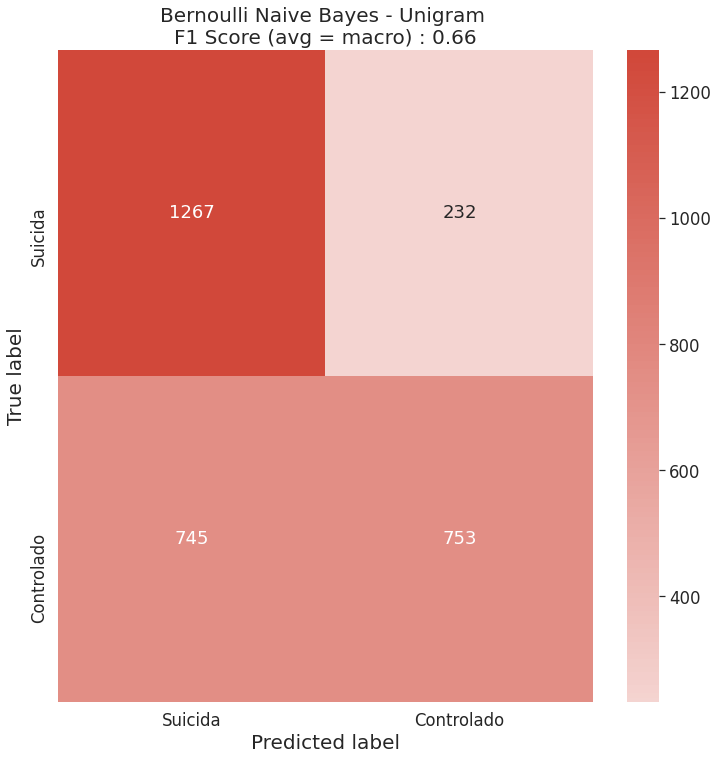

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .30, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)
model = BernoulliNB()
model.fit(X_train, y_train)
y_pred_BNV = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_BNV) 

cm_df = pd.DataFrame(cm,
                     index = ['Suicida','Controlado'], 
                     columns = ['Suicida','Controlado'])
plt.figure(figsize=(12, 12))
sns.set(font_scale = 1.5)
sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('Bernoulli Naive Bayes - Unigram \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred_BNV, average='macro')), fontsize = 20)
plt.ylabel('True label', fontsize = 20)
plt.xlabel('Predicted label', fontsize = 20)

Text(0.5, 76.5, 'Predicted label')

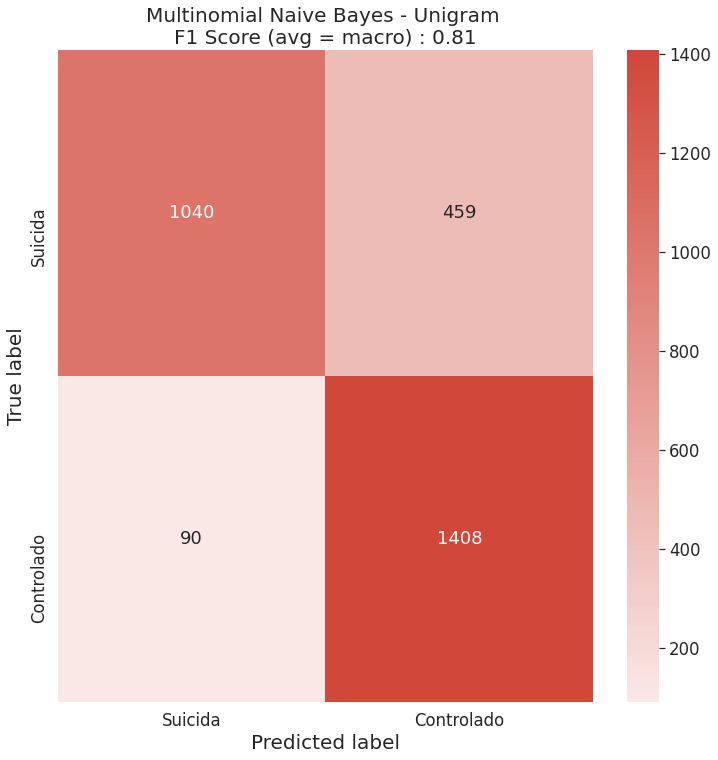

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .30, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred_MNB = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_MNB) 

cm_df = pd.DataFrame(cm,
                     index = ['Suicida','Controlado'], 
                     columns = ['Suicida','Controlado'])
plt.figure(figsize=(12, 12))
sns.set(font_scale= 1.5)
sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('Multinomial Naive Bayes - Unigram \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred_MNB, average='macro')), fontsize = 20)
plt.ylabel('True label', fontsize = 20)
plt.xlabel('Predicted label', fontsize = 20)

Text(0.5, 1.0, 'Curva ROC - AUC')

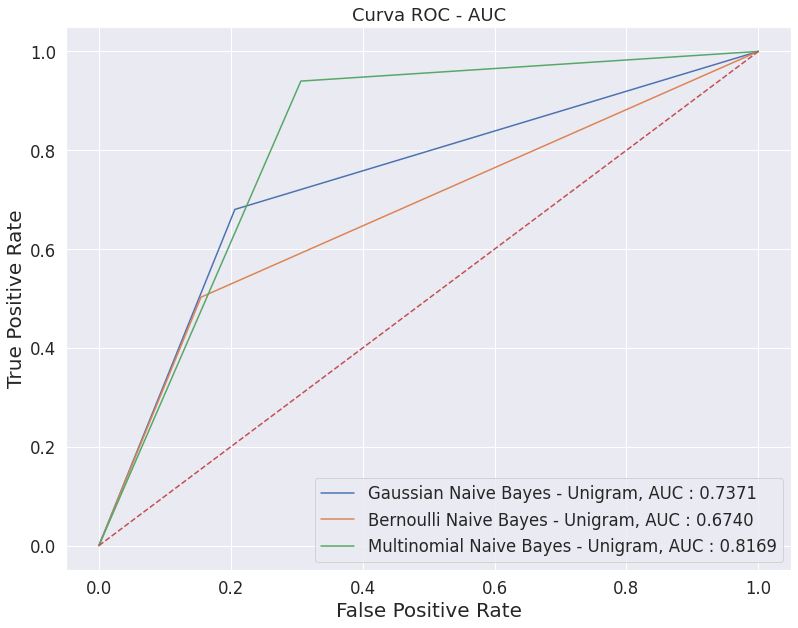

In [ ]:
plt.figure(figsize = (13, 10))
for label,y_pred_prob in zip(["Gaussian Naive Bayes - Unigram","Bernoulli Naive Bayes - Unigram","Multinomial Naive Bayes - Unigram"],
                    [y_pred_NB_Uni,y_pred_BNV,y_pred_MNB]):
  fpr,tpr,_ = roc_curve(y_test, y_pred_prob)
  plt.plot(fpr, tpr, label=label+str(", AUC : %.4f"%auc(fpr,tpr)))

plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)  
plt.legend()
plt.title('Curva ROC - AUC')

# TD-IDF unigram, regresión logistica hyperparametros

In [ ]:
texts = data['Token2'].astype('str')

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts) #features
y = data['label_num'].values #target

print (X.shape)
print(y.shape)

(9990, 8121)
(9990,)


In [ ]:
# example of grid searching key hyperparametres for logistic regression
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.864097 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.834902 (0.011671) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.836336 (0.011829) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.834868 (0.011664) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.861995 (0.008213) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.861929 (0.008270) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.862029 (0.008263) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.864097 (0.008302) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.864097 (0.008302) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.863997 (0.008205) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.834835 (0.009426) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.834835 (0.009426) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.835402 (0.009945) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.796296 (0.011038) wit

In [ ]:
model_dict = {
              'Logistic Regression liblinear': LogisticRegression(C= 10, penalty= 'l2', solver= 'liblinear'),
              'Logistic Regression newton-cg': LogisticRegression(C= 1.0, penalty= 'l2', solver= 'newton-cg'),
              'Logistic Regression lbfgs': LogisticRegression(C= 1.0, penalty= 'l2', solver= 'lbfgs')
              }

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name - unigram', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)

,model_name - unigram,accuracy_score,precision_score,recall_score,f1_score
1,Logistic Regression newton-cg,0.87,0.87,0.87,0.87
2,Logistic Regression lbfgs,0.87,0.87,0.87,0.87
0,Logistic Regression liblinear,0.87,0.87,0.87,0.87


Text(0.5, 87.0, 'Predicted label')

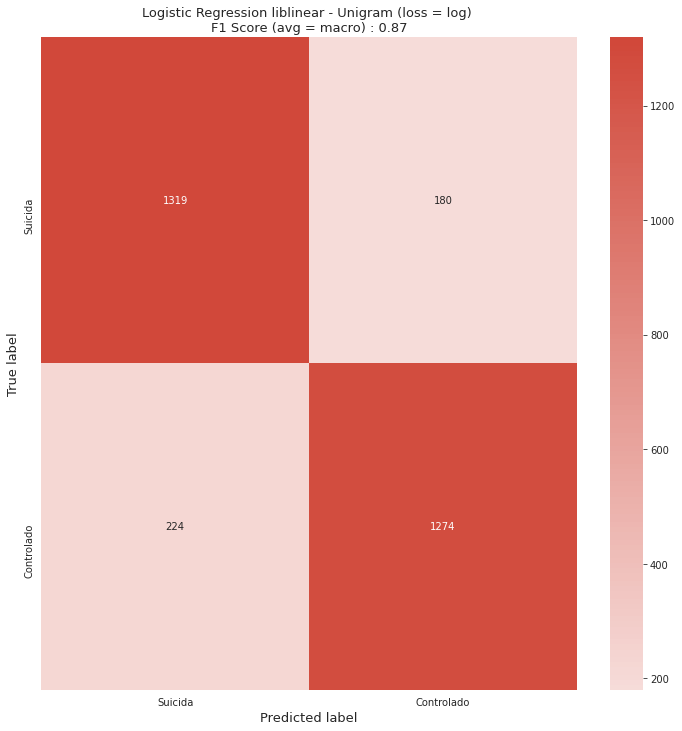

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .30, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

model = LogisticRegression(C= 10, penalty= 'l2', solver= 'liblinear')
model.fit(X_train, y_train)
y_pred_RL_liblinear = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_RL_liblinear) 

cm_df = pd.DataFrame(cm,
                     index = ['Suicida','Controlado'], 
                     columns = ['Suicida','Controlado'])
plt.figure(figsize=(12, 12))
sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('Logistic Regression liblinear - Unigram (loss = log) \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred_RL_liblinear, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)

Text(0.5, 87.0, 'Predicted label')

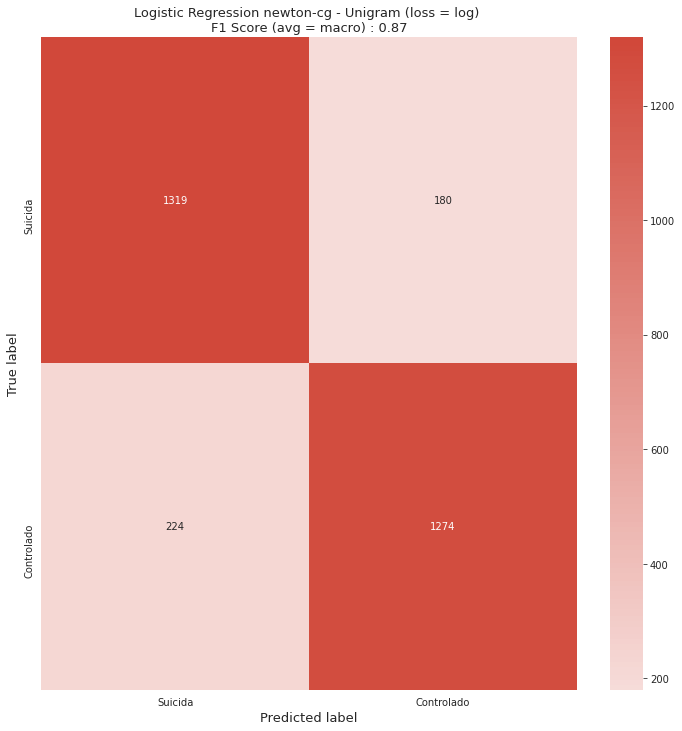

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .30, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)
model = LogisticRegression(C= 10, penalty= 'l2', solver= 'newton-cg')
model.fit(X_train, y_train)
y_pred_RL_newtoncg = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_RL_newtoncg) 

cm_df = pd.DataFrame(cm,
                     index = ['Suicida','Controlado'], 
                     columns = ['Suicida','Controlado'])
plt.figure(figsize=(12, 12))
sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('Logistic Regression newton-cg - Unigram (loss = log) \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred_RL_newtoncg, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)

Text(0.5, 87.0, 'Predicted label')

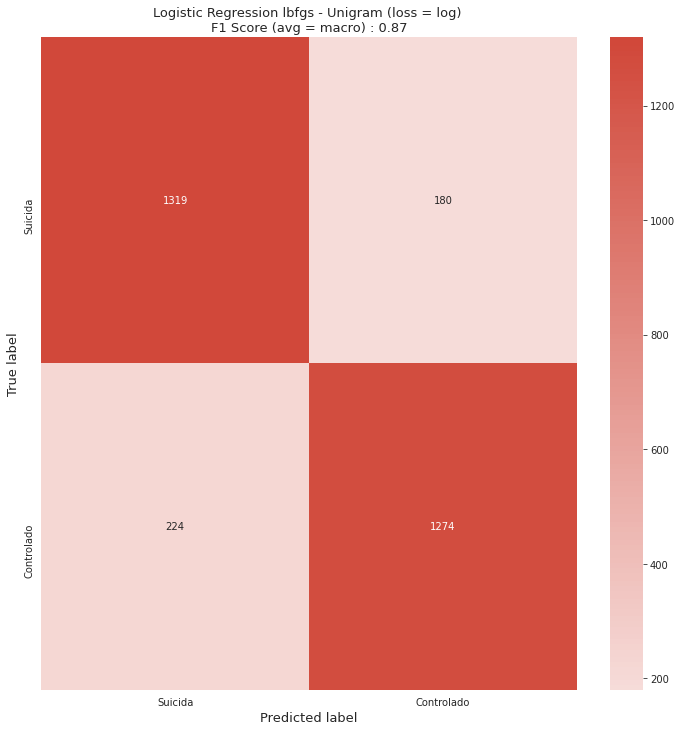

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .30, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)
model = LogisticRegression(C= 10, penalty= 'l2', solver= 'lbfgs')
model.fit(X_train, y_train)
y_pred_RL_lbfgs = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_RL_lbfgs) 

cm_df = pd.DataFrame(cm,
                     index = ['Suicida','Controlado'], 
                     columns = ['Suicida','Controlado'])
plt.figure(figsize=(12, 12))
sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('Logistic Regression lbfgs - Unigram (loss = log) \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred_RL_lbfgs, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)

Text(0.5, 1.0, 'Curva ROC - AUC')

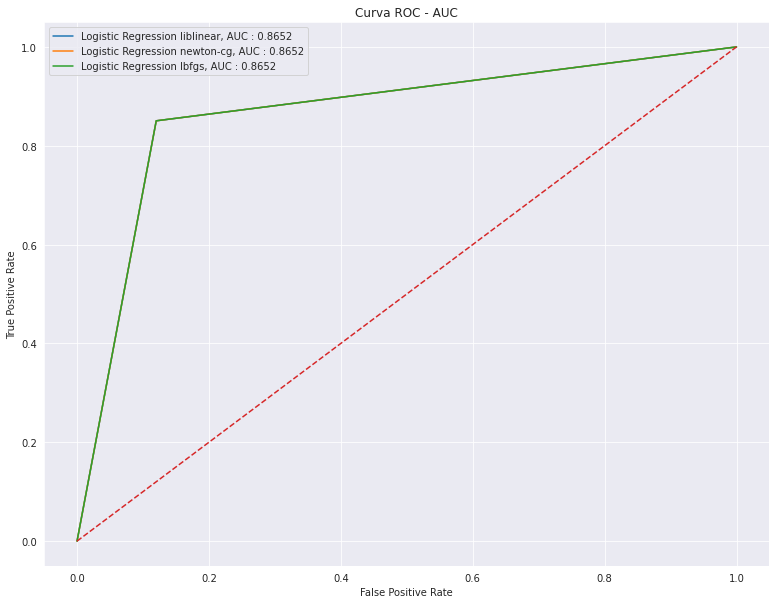

In [ ]:
plt.figure(figsize = (13, 10))
for label,y_pred_prob in zip(["Logistic Regression liblinear","Logistic Regression newton-cg","Logistic Regression lbfgs"],
                    [y_pred_RL_liblinear,y_pred_RL_newtoncg,y_pred_RL_lbfgs]):
  fpr,tpr,_ = roc_curve(y_test, y_pred_prob)
  plt.plot(fpr, tpr, label=label+str(", AUC : %.4f"%auc(fpr,tpr)))

plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('Curva ROC - AUC')